## Importing libraries

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.svm import SVC
from sklearn.metrics import f1_score

## Data pre-processing

In [1]:

# List of response and time file paths
response_files = ['responseFile_1.csv', 'responseFile_3.csv', 'responseFile_4.csv', 'responseFile_5.csv', 'responseFile_6.csv', 'responseFile_7.csv']
time_files = ['timeFile_1.csv', 'timeFile_3.csv', 'timeFile_4.csv', 'timeFile_5.csv', 'timeFile_6.csv', 'timeFile_7.csv']

# Initialize DataFrames to hold the merged data
merged_response = pd.DataFrame()
merged_time = pd.DataFrame()
end_time = 0  # Initialize the end time

# Iterate through response and time files
for response_file, time_file in zip(response_files, time_files):
    # Load response and time DataFrames
    response_df = pd.read_csv(response_file)
    time_df = pd.read_csv(time_file)
    # for angles, center them at 180
    # (180 + pitch) % 360
    response_df[' Pitch'] =  round(((response_df[' Pitch'] + 180) % 360 ), 2)
    response_df[' Roll'] = round(((response_df[' Roll'] + 180) % 360),2) 
    time_df['Pitch'] = round(((time_df[' Pitch'] + 180) % 360 ),2)
    time_df[' Roll'] = round(((time_df[' Roll'] + 180) % 360),2) 



    # Shift time values in time_df
    time_df['Elapsed Time (ms)'] += end_time

    # Update the start time for response_df
    response_df['Elapsed Time (ms)'] += end_time

    # Concatenate response and time DataFrames
    merged_response = pd.concat([merged_response, response_df], ignore_index=True)
    merged_time = pd.concat([merged_time, time_df], ignore_index=True)

    # Update the end time
    end_time = time_df['Elapsed Time (ms)'].max()

# Save merged response and time DataFrames to new CSV files
merged_response.to_csv('merged_response.csv', index=False)
merged_time.to_csv('merged_time.csv', index=False)


In [9]:
# List of response and time file paths
response_files = ['responseFile_1.csv', 'responseFile_2.csv', 'responseFile_3.csv', 'responseFile_4.csv', 'responseFile_5.csv', 'responseFile_6.csv', 'responseFile_7.csv']
time_files = ['timeFile_1.csv', 'timeFile_2.csv', 'timeFile_3.csv', 'timeFile_4.csv', 'timeFile_5.csv', 'timeFile_6.csv', 'timeFile_7.csv']

# Initialize DataFrames to hold the merged data
merged_response = pd.DataFrame()
merged_time = pd.DataFrame()
end_time = 0  # Initialize the end time

# Iterate through response and time files
for response_file, time_file in zip(response_files, time_files):
    # Load response and time DataFrames
    response_df = pd.read_csv(response_file)
    time_df = pd.read_csv(time_file)

    # for angles, center them at 180
    response_df[' Pitch'] = round(((response_df[' Pitch'] + 180) % 360), 2)
    response_df[' Roll'] = round(((response_df[' Roll'] + 180) % 360), 2)

    # Update time_df and remove old ' Pitch' and ' Roll' columns
    time_df['Pitch'] = round(((time_df[' Pitch'] + 180) % 360), 2)
    time_df['Roll'] = round(((time_df[' Roll'] + 180) % 360), 2)
    time_df.drop(columns=[' Pitch', ' Roll'], inplace=True)  # Drop the original columns

    # Shift time values in time_df
    time_df['Elapsed Time (ms)'] += end_time

    # Update the start time for response_df
    response_df['Elapsed Time (ms)'] += end_time

    # Concatenate response and time DataFrames
    merged_response = pd.concat([merged_response, response_df], ignore_index=True)
    merged_time = pd.concat([merged_time, time_df], ignore_index=True)

    # Update the end time
    end_time = time_df['Elapsed Time (ms)'].max()

# Save merged response and time DataFrames to new CSV files using float_format to ensure 2 decimal places
merged_response.to_csv('merged_response.csv', index=False, float_format='%.2f')
merged_time.to_csv('merged_time.csv', index=False, float_format='%.2f')


In [ ]:
# Read the response_csv and time_csv into DataFrames
# response_df = pd.read_csv('merged_response.csv')
# time_df = pd.read_csv('data/timeFile_20230904_1513.csv')
# Read the response_csv and time_csv into DataFrames
response_df = pd.read_csv('merged_response.csv')
time_df = pd.read_csv('merged_time.csv')

# Remove spaces from column names in response_df
response_df.columns = response_df.columns.str.strip()

# Remove spaces from column names in time_df
time_df.columns = time_df.columns.str.strip()
# Remove spaces from column values in response_df
response_df = response_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Remove spaces from column values in time_df
time_df = time_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Specify the time_window in milliseconds
time_window = 5000  # Adjust this value as needed

# Function to calculate statistics within the time_window
def calculate_statistics(row):
    start_time = row['Elapsed Time (ms)'] - time_window
    relevant_data = time_df[(time_df['Elapsed Time (ms)'] >= start_time) & (time_df['Elapsed Time (ms)'] <= row['Elapsed Time (ms)'])]
    pitch_values = relevant_data['Pitch'].round().astype(int)
    yaw_values = relevant_data['Yaw'].round().astype(int)
    roll_values = relevant_data['Roll'].round().astype(int)

    std_pitch = pitch_values.std()
    var_pitch = pitch_values.var()
    mean_pitch = pitch_values.mean()
    mode_pitch = mode(pitch_values, axis=None)[0]
    median_pitch = pitch_values.median()

    std_yaw = yaw_values.std()
    var_yaw = yaw_values.var()
    mean_yaw = yaw_values.mean()
    mode_yaw = mode(yaw_values, axis=None)[0]
    median_yaw = yaw_values.median()

    std_roll = roll_values.std()
    var_roll = roll_values.var()
    mean_roll = roll_values.mean()
    mode_roll = mode(roll_values, axis=None)[0]
    median_roll = roll_values.median()

    return pd.Series({
        'std_pitch': round(std_pitch, 2),
        'var_pitch': round(var_pitch, 2),
        'mean_pitch': round(mean_pitch, 2),
        'mode_pitch': round(mode_pitch,2),   # Assuming this will always be a whole number
        'median_pitch': round(median_pitch, 2),
        'std_yaw': round(std_yaw, 2),
        'var_yaw': round(var_yaw, 2),
        'mean_yaw': round(mean_yaw, 2),
        'mode_yaw': round(mode_yaw,2),       # Assuming this will always be a whole number
        'median_yaw': round(median_yaw, 2),
        'std_roll': round(std_roll, 2),
        'var_roll': round(var_roll, 2),
        'mean_roll': round(mean_roll, 2),
        'mode_roll': round(mode_roll,2),     # Assuming this will always be a whole number
        'median_roll': round(median_roll, 2)
    })

# Convert 'Pitch', 'Yaw', and 'Roll' to integers in response_df and time_df
response_df['Pitch'] = response_df['Pitch'].round().astype(int)
response_df['Yaw'] = response_df['Yaw'].round().astype(int)
response_df['Roll'] = response_df['Roll'].round().astype(int)

time_df['Pitch'] = time_df['Pitch'].round().astype(int)
time_df['Yaw'] = time_df['Yaw'].round().astype(int)
time_df['Roll'] = time_df['Roll'].round().astype(int)

# Apply the function to each row in the response DataFrame
statistics_df = response_df.apply(calculate_statistics, axis=1)

# Concatenate the statistics DataFrame with the response DataFrame
merged_df = pd.concat([response_df, statistics_df], axis=1)

# Create the 'attentive' column
merged_df['Attentive'] = response_df['Correct'].apply(lambda x: 0 if x == 'No' else 1)

# Save the final DataFrame to a new CSV file
merged_df.to_csv('responseFile_with_statistics.csv', index=False, float_format='%.2f')



### HeatMap

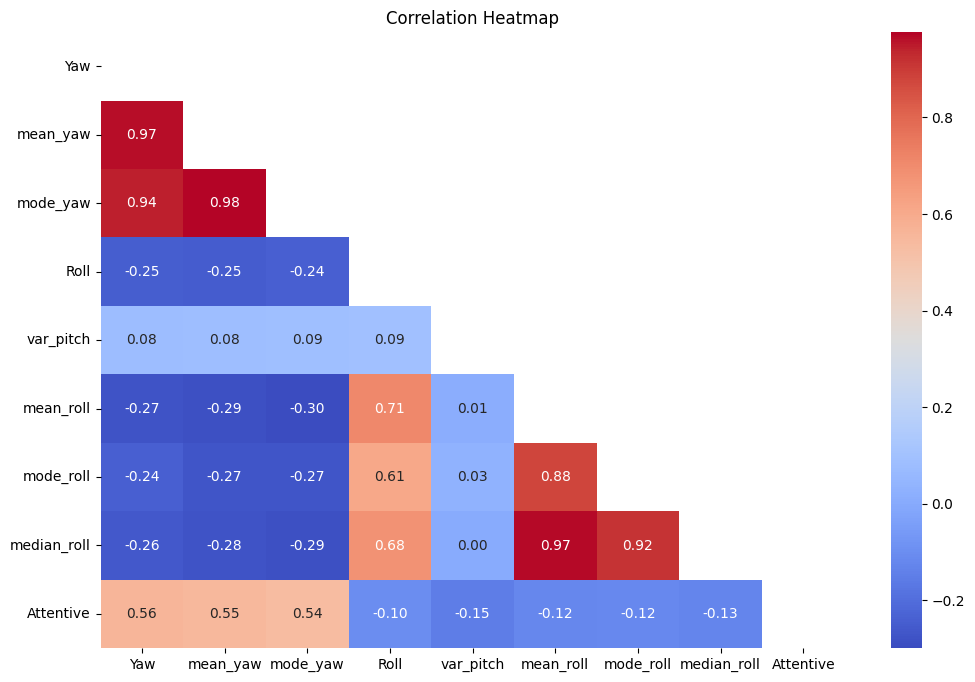

In [6]:


# Read the DataFrame
merged_df = pd.read_csv('modified_responseFile_with_statistics.csv')

# Filter out only the columns of interest
selected_columns = merged_df.select_dtypes(include=['int64', 'float64'])
# Compute the correlation matrix for these columns
selected_columns = merged_df[['Yaw', 'mean_yaw', 'mode_yaw', 'Roll', 'var_pitch', 'mean_roll','mode_roll', 'median_roll' , 'Attentive']]
            
correlation_matrix_selected = selected_columns.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_selected, dtype=bool))

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_selected, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


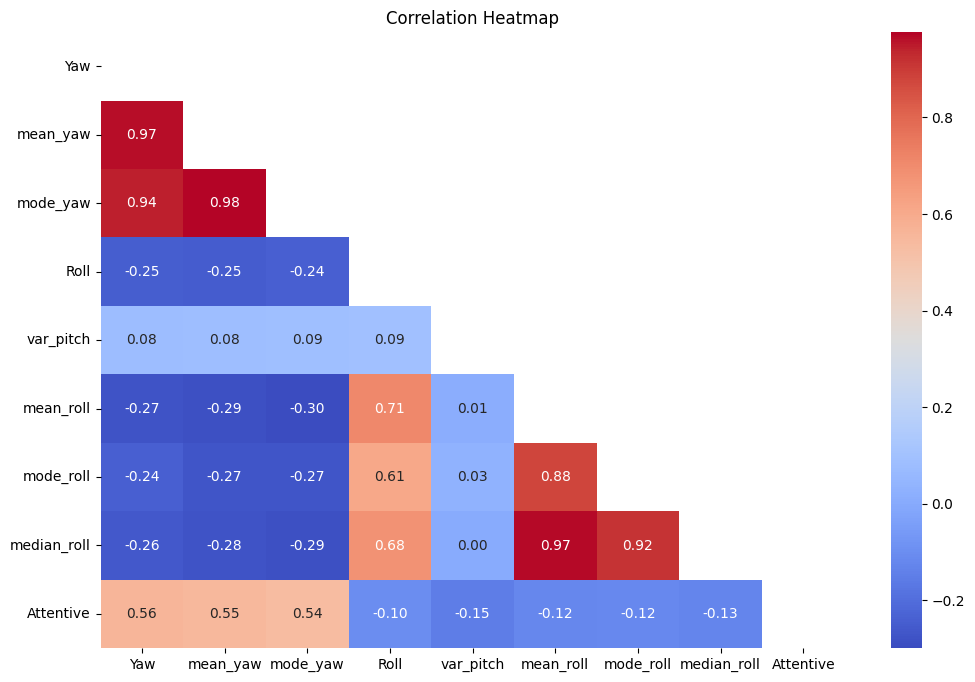

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the DataFrame
merged_df = pd.read_csv('modified_responseFile_with_statistics.csv')

# Filter out only the columns of interest
selected_columns = merged_df.select_dtypes(include=['int64', 'float64'])
# Compute the correlation matrix for these columns
selected_columns = merged_df[['Yaw', 'mean_yaw', 'mode_yaw', 'Roll', 'var_pitch', 'mean_roll','mode_roll', 'median_roll' , 'Attentive']]
            
correlation_matrix_selected = selected_columns.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_selected, dtype=bool))

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_selected, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


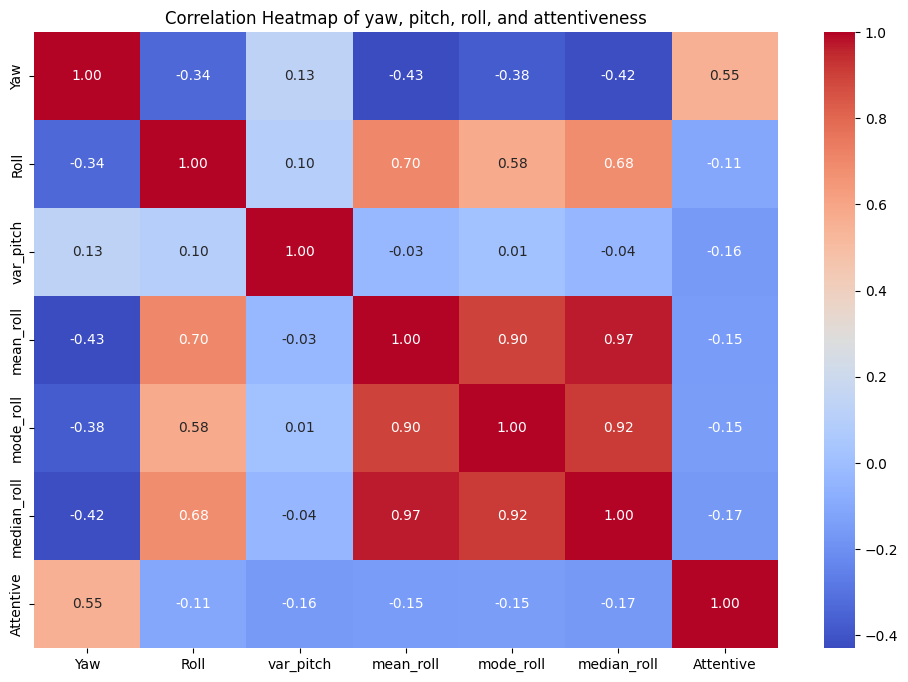

In [7]:
# Read the DataFrame
merged_df = pd.read_csv('modified_responseFile_with_statistics.csv')

# Filter out only the columns of interest: yaw, pitch, roll, and attentiveness
selected_columns = merged_df[['Yaw', 'Roll', 'var_pitch', 'mean_roll','mode_roll', 'median_roll' , 'Attentive']]

# Compute the correlation matrix for these columns
correlation_matrix_selected = selected_columns.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_selected, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of yaw, pitch, roll, and attentiveness')
plt.show()


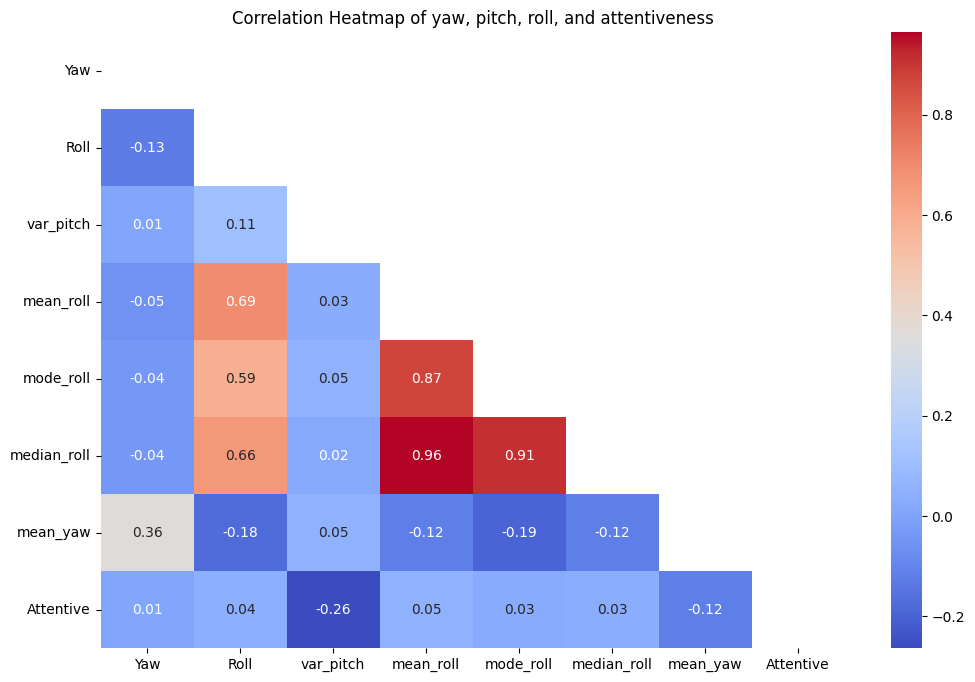

In [3]:

# Read the DataFrame
merged_df = pd.read_csv('modified_responseFile_with_statistics.csv')

# Filter out only the columns of interest
selected_columns = merged_df[['Yaw', 'Roll', 'var_pitch', 'mean_roll','mode_roll', 'median_roll', 'mean_yaw', 'Attentive']]

# Compute the correlation matrix for these columns
correlation_matrix_selected = selected_columns.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_selected, dtype=bool))

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_selected, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of yaw, pitch, roll, and attentiveness')
plt.show()


### Reduce number of positive classes

In [3]:

# Read the CSV into a DataFrame
df = pd.read_csv('responseFile_with_statistics.csv')

# Filter rows where Attentive = 1 and shuffle
attentive_rows = df[df['Attentive'] == 1].sample(frac=1, random_state=42)

# Filter rows where Attentive != 1
non_attentive_rows = df[df['Attentive'] != 1]

# Concatenate the DataFrames
final_df = pd.concat([attentive_rows, non_attentive_rows], axis=0).sort_index()

# Save the final DataFrame to a new CSV file
final_df.to_csv('modified_responseFile_with_statistics.csv', index=False)

Baseline Accuracy: 0.9292929292929293
Baseline Confusion Matrix:
[[  2   9]
 [  5 182]]
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.18      0.22        11
           1       0.95      0.97      0.96       187

    accuracy                           0.93       198
   macro avg       0.62      0.58      0.59       198
weighted avg       0.92      0.93      0.92       198



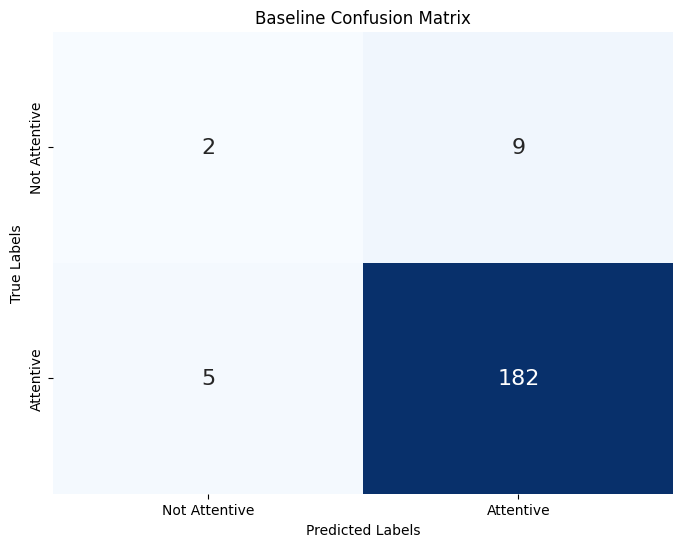

In [4]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Read your preprocessed DataFrame (responseFile_with_statistics.csv)
df = pd.read_csv('modified_responseFile_with_statistics.csv')

# Select the features and the target variable
features = df[['Yaw', 'std_yaw', 'mean_yaw', 'mode_yaw', 'median_yaw']]
target = df['Attentive']

# Select only the rows where the target variable is 0 or 1
target = target[target.isin([0, 1])]

# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Baseline model: Predict 1 if Yaw is between 150 and 200, else predict 0
y_pred_baseline = (X_test['Yaw'] >= 150) & (X_test['Yaw'] <= 200)
y_pred_baseline = y_pred_baseline.astype(int)  # Convert boolean values to integers

# Evaluate the baseline model
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
confusion_baseline = confusion_matrix(y_test, y_pred_baseline)
report_baseline = classification_report(y_test, y_pred_baseline)

print(f'Baseline Accuracy: {accuracy_baseline}')
print('Baseline Confusion Matrix:')
print(confusion_baseline)
print('Baseline Classification Report:')
print(report_baseline)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_baseline, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 16}, xticklabels=['Not Attentive', 'Attentive'], yticklabels=['Not Attentive', 'Attentive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Baseline Confusion Matrix')
plt.show()


## Train-Test split

In [51]:
# Read your preproces
df = pd.read_csv('responseFile_with_statistics.csv')

# Select the features and the target variable
features = df[[
    'Yaw',
    'Pitch',
    'Roll',
    'std_pitch',
    'var_pitch',
    'mean_pitch',
    'median_pitch',
    'std_yaw',
    'var_yaw',
    'mean_yaw',
    'median_yaw',
    'std_roll',
    'var_roll',
    'mean_roll',
    'median_roll'
    ]]

# target class
y = df['Attentive']

# Scale the data
sc = StandardScaler()
features_scaled = sc.fit_transform(features)

# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(features_scaled, y, stratify=y, test_size=0.2, random_state=42)

## SVM

F1 score for test data: 87.31%
Accuracy: 0.9141414141414141
Confusion Matrix:
[[  0  17]
 [  0 181]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.91      1.00      0.96       181

    accuracy                           0.91       198
   macro avg       0.46      0.50      0.48       198
weighted avg       0.84      0.91      0.87       198



c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

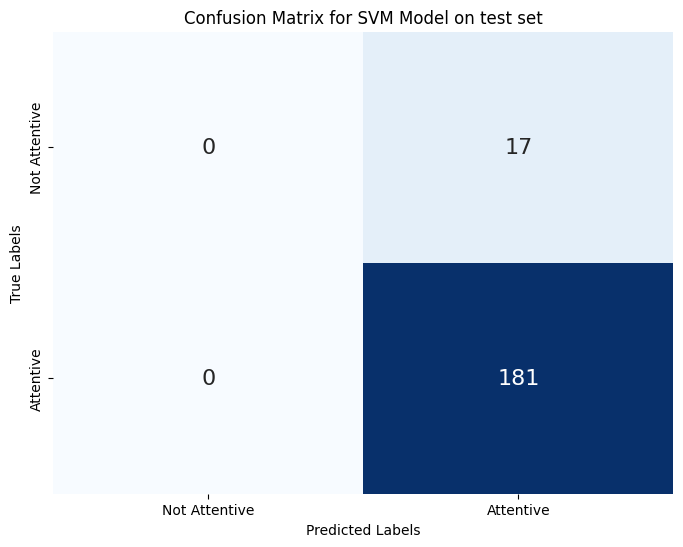

In [60]:
# Create and train the Support Vector Machine (SVM) model
svm = SVC(kernel='linear')  # You can choose different kernels (linear, radial basis function, etc.)
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Evaluate the model
score = f1_score(y_test, y_pred, average='weighted')
print(f'F1 score for test data: {score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 16}, xticklabels=['Not Attentive', 'Attentive'], yticklabels=['Not Attentive', 'Attentive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM Model on test set') 
plt.show()

F1 score for test data: 87.77%
Accuracy: 0.9164556962025316
Confusion Matrix:
[[  1  66]
 [  0 723]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.03        67
           1       0.92      1.00      0.96       723

    accuracy                           0.92       790
   macro avg       0.96      0.51      0.49       790
weighted avg       0.92      0.92      0.88       790



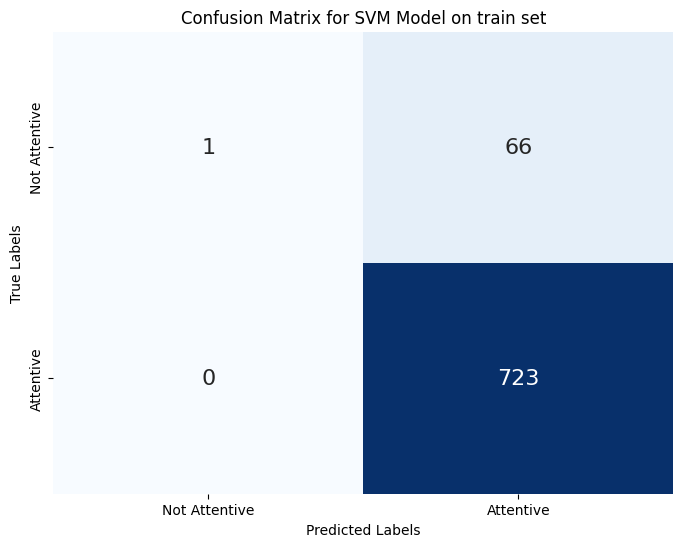

In [55]:
# Make predictions on the test set
y_pred = svm.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred)
confusion = confusion_matrix(y_train, y_pred)
report = classification_report(y_train, y_pred)

score = f1_score(y_train, y_pred, average='weighted')
print(f'F1 score for test data: {score*100:.2f}%')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 16}, xticklabels=['Not Attentive', 'Attentive'], yticklabels=['Not Attentive', 'Attentive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM Model on train set')
plt.show()


## Random Forest

F1 score for train data: 99.75%
Accuracy: 0.9974683544303797
Confusion Matrix:
[[ 65   2]
 [  0 723]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        67
           1       1.00      1.00      1.00       723

    accuracy                           1.00       790
   macro avg       1.00      0.99      0.99       790
weighted avg       1.00      1.00      1.00       790



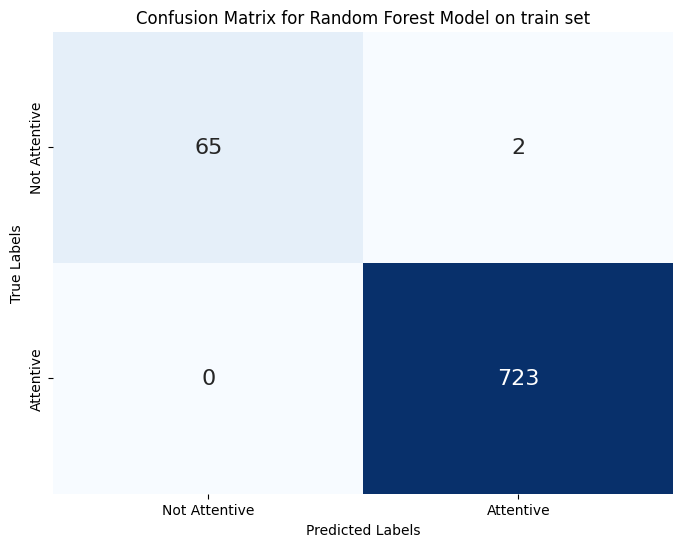

In [58]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_train)
# Evaluate the model
accuracy = accuracy_score(y_train, y_pred)
confusion = confusion_matrix(y_train, y_pred)
report = classification_report(y_train, y_pred)

score = f1_score(y_train, y_pred, average='weighted')
print(f'F1 score for train data: {score*100:.2f}%')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 16}, xticklabels=['Not Attentive', 'Attentive'], yticklabels=['Not Attentive', 'Attentive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Model on train set')
plt.show()

F1 score for test data: 87.60%
Accuracy: 0.9040404040404041
Confusion Matrix:
[[  1  16]
 [  3 178]]
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.06      0.10        17
           1       0.92      0.98      0.95       181

    accuracy                           0.90       198
   macro avg       0.58      0.52      0.52       198
weighted avg       0.86      0.90      0.88       198



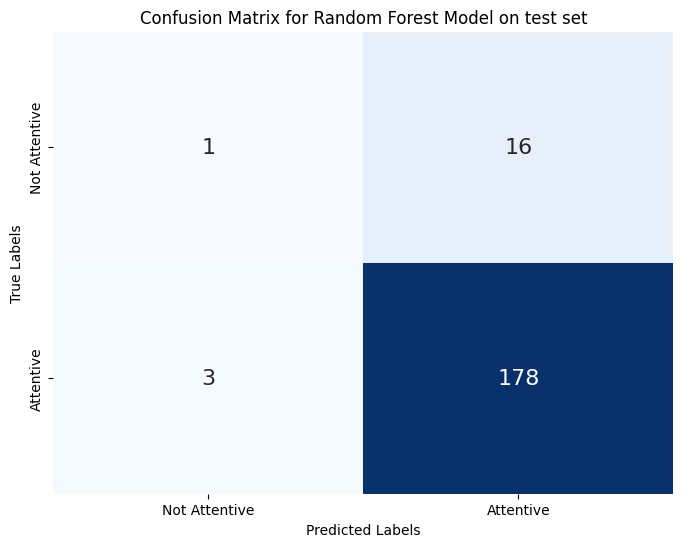

In [59]:
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

score = f1_score(y_test, y_pred, average='weighted')
print(f'F1 score for test data: {score*100:.2f}%')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 16}, xticklabels=['Not Attentive', 'Attentive'], yticklabels=['Not Attentive', 'Attentive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Model on test set')
plt.show()

## Neural Network

In [120]:

# Define the ANN model
model = Sequential([
    Dense(1024, activation='relu', input_shape=(features.shape[1],)),
    Dropout(0.7),
    Dense(32, activation='relu'),
    Dropout(0.7),
    Dense(8, activation='relu'),
    Dropout(0.25), 
    Dense(1, activation='sigmoid')
])

In [121]:
# Compile the model
lr = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredLogarithmicError(), metrics=['accuracy'])

In [122]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), class_weight={0: 5, 1: 1}, verbose=0)

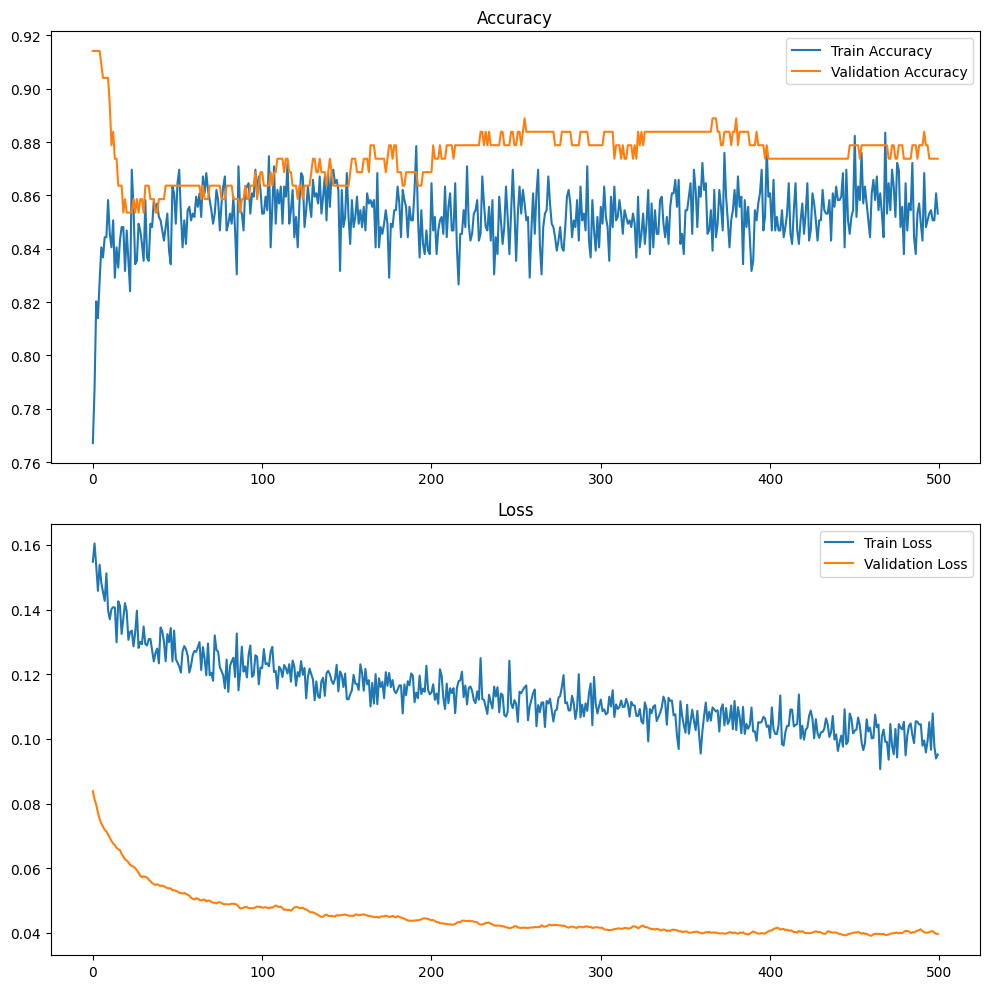

In [123]:
# Plot accuracy and loss
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].legend()
ax[1].set_title('Loss')

plt.tight_layout()
plt.show()

7/7 [==============================] - 0s 1ms/step
Accuracy: 0.8737373737373737
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.41      0.36        17
           1       0.94      0.92      0.93       181

    accuracy                           0.87       198
   macro avg       0.63      0.66      0.64       198
weighted avg       0.89      0.87      0.88       198



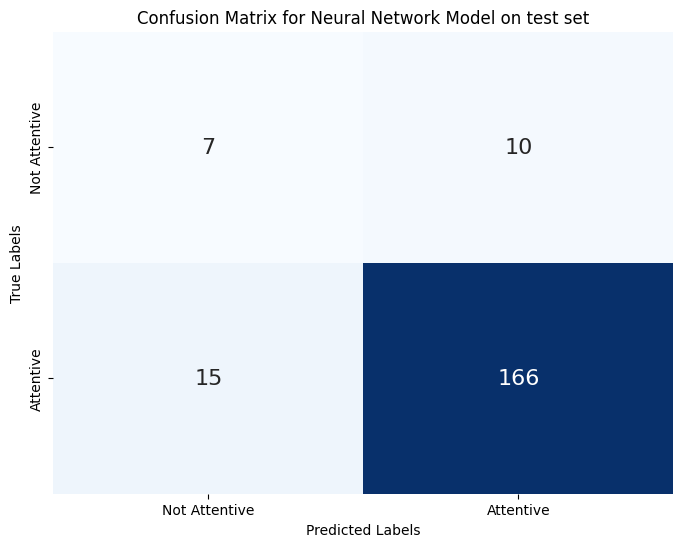

In [124]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
# Generate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)
 
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 16}, xticklabels=['Not Attentive', 'Attentive'], yticklabels=['Not Attentive', 'Attentive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Network Model on test set')
plt.show()

In [125]:
score = f1_score(y_test, y_pred, average='weighted')
print(f'F1 score for test data: {score*100:.2f}%')

F1 score for test data: 88.09%


 1/25 [>.............................] - ETA: 0s

25/25 [==============================] - 0s 772us/step
Accuracy: 0.8737373737373737
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.70      0.50        67
           1       0.97      0.90      0.93       723

    accuracy                           0.88       790
   macro avg       0.68      0.80      0.72       790
weighted avg       0.92      0.88      0.90       790



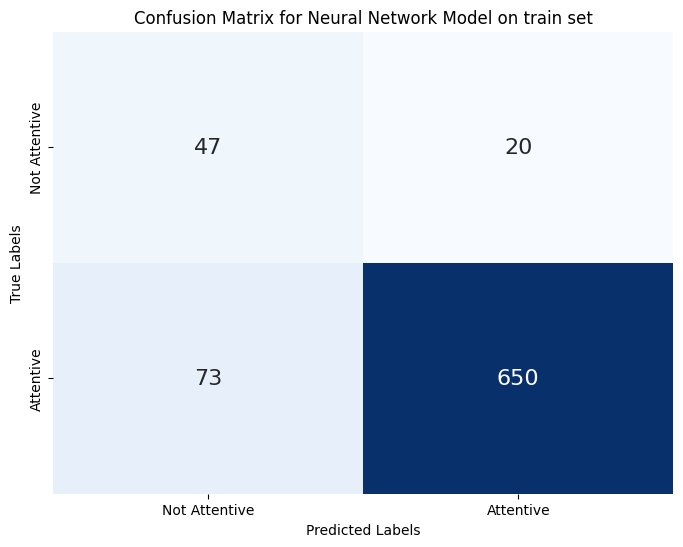

In [126]:
y_pred = (model.predict(X_train) > 0.5).astype(int)
# Generate the confusion matrix
confusion = confusion_matrix(y_train, y_pred)

report = classification_report(y_train, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 16}, xticklabels=['Not Attentive', 'Attentive'], yticklabels=['Not Attentive', 'Attentive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Network Model on train set')
plt.show()

In [127]:
score = f1_score(y_train, y_pred, average='weighted')
print(f'F1 score for training data: {score*100:.2f}%')

F1 score for training data: 89.67%
